# OCHRE User Tutorial

OCHRE&trade; is a Python-based energy modeling tool designed to model end-use
loads and distributed energy resources in residential buildings. It can model
flexible devices---including HVAC equipment, water heaters, electric vehicles,
solar PV, and batteries---and the thermal and electrical interactions between
them. OCHRE has been used to generate diverse and high-resolution load
profiles, examine the impacts of advanced control strategies on energy costs
and occupant comfort, and assess grid reliability and resilience through
building-to-grid co-simulation.

This tutorial covers the basics of how to install and run OCHRE, and provides
some examples for various use cases. It can be downloaded online
[here](https://github.com/NREL/OCHRE/blob/main/notebook/user_tutorial.ipynb).

More information about OCHRE can be found in [our
documentation](https://ochre-nrel.readthedocs.io/), on [NREL's
website](https://www.nrel.gov/grid/ochre.html), and from the [Powered By
OCHRE](https://www.youtube.com/watch?v=B5elLVtYDbI) webinar recording.

If you use OCHRE for your research or other projects, please fill out our
[user survey](https://forms.office.com/g/U4xYhaWEvs).

* [Set up](#setup)
  * [Running online](#online)
  * [Local installation](#install)
  * [Getting input files](#inputs)
* [Simulating a dwelling](#dwelling)
  * [Simulating a sample dwelling](#sample)
  * [Adding equipment to a dwelling](#add-equipment)
  * [Downloading input files](#download)
  * [Running through the command line](#cli)
* [Simulating a single piece of equipment](#equipment)
  * [Electric vehicle](#ev)
  * [Water heater](#water_heater)
* [Simulating a fleet](#fleet)
  * [EV fleet](#ev-fleet)
  * [Multiple houses](#house-fleet)
* [Simulating with external controllers](#control)
  * [HVAC setpoint control](#hvac-control)
  * [EV managed charging](#ev-control)
  * [HPWH CTA-2045 control](#wh-control)


## <a name="setup"></a>Set up


### <a name="online"></a>Running online

OCHRE can be run online through an interactive Jupyter notebook. The code
below will install OCHRE in the current environment.

**Note for Google Colab users**: You may need to restart the notebook after
installing OCHRE (see Runtime > Restart Session). There may be errors or
warnings about dependency issues, but these will not affect the code in this
notebook.


In [1]:
# pip install ochre-nrel

### <a name="install"></a>Local installation

The latest release of OCHRE can be installed using `pip` from the command line with:

```
pip install ochre-nrel
```

Advanced users and developers can also install a specific branch from Github, for example:

```
pip install git+https://github.com/NREL/OCHRE@dev
```

Note that OCHRE currently requires Python version >=3.9 and <3.13.

### <a name="inputs"></a>Getting input files

OCHRE `Dwelling` models typically require 3 inputs files:
* An HPXML file with building and equipment properties (.xml)
* An HPXML schedule file with occupant usage profiles (.csv)
* A weather file (.epw, or .csv with NSRDB format)

There are [multiple
ways](https://ochre-nrel.readthedocs.io/en/latest/InputsAndArguments.html#getting-input-files)
to generate or download OCHRE input files. An example below shows how to
[download input files](#download).


## <a name="dwelling"></a>Simulating a dwelling

OCHRE is most commonly used to model an entire residential dwelling (i.e., a
house, apartment, or other housing unit) with many pieces of energy-consuming
equipment. Using information about the building, equipment, occupants, and
weather, it will generate a load profile and other relevant results. This
tutorial shows examples on running a sample dwelling, adding additional
equipment, and downloading a building model from ResStock Datasets.



### <a name="sample"></a>Simulating a sample dwelling

The following code will initialize a Dwelling using [sample
files](https://github.com/NREL/OCHRE/tree/main/ochre/defaults/Input%20Files)
from the [ResStock 2024.2 dataset](https://resstock.nrel.gov/datasets) and
from the [EnergyPlus website](https://energyplus.net/weather) (for weather
data). In addition to specifying input files, OCHRE requires a simulation
start time, time resolution, and duration.




In [2]:
import os                                   # Provides functions for interacting with the operating system (e.g., file paths)
import datetime as dt                       # Used to handle date and time objects for simulation setup

from ochre import Dwelling                  # Imports the Dwelling class from the OCHRE package (main building model object)

# Define the absolute path to the project root directory (one level above current working directory)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Define the path to the folder that contains OCHRE’s default input files (HPXML, schedules, and weather data)
default_input_path = os.path.join(PROJECT_ROOT, "ochre", "defaults")

# Define a dictionary of arguments to configure the Dwelling simulation
dwelling_args = {
    # Timing parameters
    "start_time": dt.datetime(2018, 1, 1, 0, 0),  # (year, month, day, hour, minute)
    "time_res": dt.timedelta(minutes=10),         # time resolution of the simulation (each step is 10 minutes)
    "duration": dt.timedelta(days=3),             # duration of the simulation (total simulated period = 3 days)

    # Input files
    "hpxml_file": os.path.join(default_input_path, "Input Files", "bldg0112631-up11.xml"),  # path to HPXML file defining building geometry, systems, etc.
    "hpxml_schedule_file": os.path.join(default_input_path, "Input Files", "bldg0112631_schedule.csv"),  # path to CSV file defining occupancy and internal load schedules
    "weather_file": os.path.join(default_input_path, "Weather", "USA_CO_Denver.Intl.AP.725650_TMY3.epw"),  # path to EPW weather file for Denver, CO
}

# Create Dwelling model instance using the defined parameters and input files
# This loads the building description, schedule, and weather into the simulation model
dwelling = Dwelling(**dwelling_args)

2025-11-10 19:59:08.687086 - ochre at 2018-01-01 00:00:00: Initializing ochre (OCHRE v0.9.1)
2025-11-10 19:59:19.767555 - ochre at 2018-01-01 00:00:00: Dwelling Initialized


The following code will simulate the dwelling. By default, it will return the
following results and save them to files:

- `df`: a Pandas DataFrame of time series results
- `metrics`: a dictionary of energy metrics
- `hourly`: a Pandas DataFrame of time series results with 1 hour resolution

In [3]:
df, metrics, hourly = dwelling.simulate()

2025-11-10 19:59:19.784080 - ochre at 2018-01-01 00:00:00: Running Simulation for 3 days, 0:00:00
2025-11-10 19:59:20.903198 - ochre at 2018-01-04 00:00:00: Simulation complete, time series results saved to: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre.csv
2025-11-10 19:59:20.907772 - ochre at 2018-01-04 00:00:00: Post-processing metrics saved to: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre_metrics.csv
2025-11-10 19:59:20.915803 - ochre at 2018-01-04 00:00:00: Hourly results saved to: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre_hourly.csv


The time series results include the total house power&mdash;including electricity
real and reactive power and natural gas consumption&mdash;building zone
temperatures, and unmet HVAC load. Many [additional
results](https://ochre-nrel.readthedocs.io/en/latest/Outputs.html) can be
saved by increasing the `verbosity` of the simulation (default is 3).

In [4]:
df.head()

,Total Electric Power (kW),Total Reactive Power (kVAR),Total Gas Power (therms/hour),Other Electric Power (kW),Water Heating Electric Power (kW),HVAC Cooling Electric Power (kW),HVAC Heating Electric Power (kW),Lighting Electric Power (kW),Hot Water Unmet Demand (kW),Hot Water Outlet Temperature (C),Temperature - Indoor (C),Unmet HVAC Load (C)
Time,,,,,,,,,,,,
2018-01-01 00:00:00,9.521264,6.145515,0.0,0.230687,0.001,0.05,9.223305,0.016273,0.0,51.111111,20.544582,0
2018-01-01 00:10:00,8.866912,5.722846,0.0,0.230687,0.001,0.05,8.568952,0.016273,0.0,51.065527,20.649424,0
2018-01-01 00:20:00,8.846848,5.709886,0.0,0.230687,0.001,0.05,8.548888,0.016273,0.0,51.020132,20.649424,0
2018-01-01 00:30:00,8.841985,5.706744,0.0,0.230687,0.001,0.05,8.544025,0.016273,0.0,50.973995,20.649424,0
2018-01-01 00:40:00,8.845694,5.709140,0.0,0.230687,0.001,0.05,8.547735,0.016273,0.0,50.928248,20.649424,0


Metrics include the total house electricity and natural gas energy consumed,
peak electric power, average zone temperatures, and total unmet HVAC load. Many [additional
metrics](https://ochre-nrel.readthedocs.io/en/latest/Outputs.html#all-metrics) can be
saved by increasing the `metrics_verbosity` of the simulation (default is 3).


In [5]:
metrics

{'Total Electric Energy (kWh)': 219.3257994006883,
 'Total Gas Energy (therms)': 0.0,
 'Average Electric Power (kW)': 3.0461916583428934,
 'Peak Electric Power (kW)': 9.521264270040879,
 'Other Electric Energy (kWh)': 35.03264935420963,
 'Water Heating Electric Energy (kWh)': 5.199970758336843,
 'HVAC Cooling Electric Energy (kWh)': 3.6,
 'HVAC Heating Electric Energy (kWh)': 169.8536016401393,
 'Lighting Electric Energy (kWh)': 5.639577648002511,
 'Average Temperature - Indoor (C)': 20.67023807289054,
 'Unmet Heating Load (C-hours)': 0.0,
 'Unmet Cooling Load (C-hours)': 0.0,
 'Total Hot Water Unmet Demand (kWh)': 0.0}

The `Analysis` module has useful data analysis functions for OCHRE output
data. The following code will recalculate the metrics
from the previous run:


In [6]:
from ochre import Analysis

# calculate metrics from the time series results
metrics2 = Analysis.calculate_metrics(df)


The `CreateFigures` module has useful visualization functions for OCHRE output
data. The following code will create a stacked plot of house power by end use:



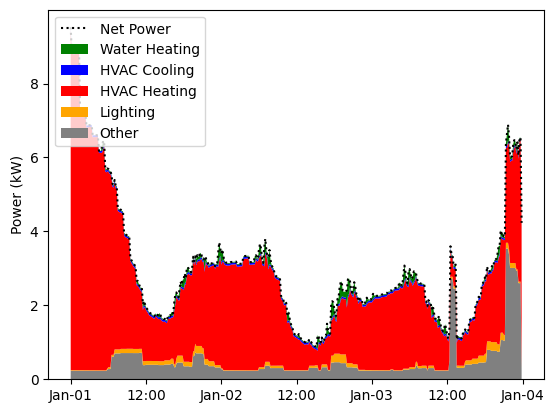

In [7]:
%matplotlib inline

from ochre import CreateFigures

# Plot results
fig = CreateFigures.plot_power_stack(df)

The following code will plot the average daily load profile:

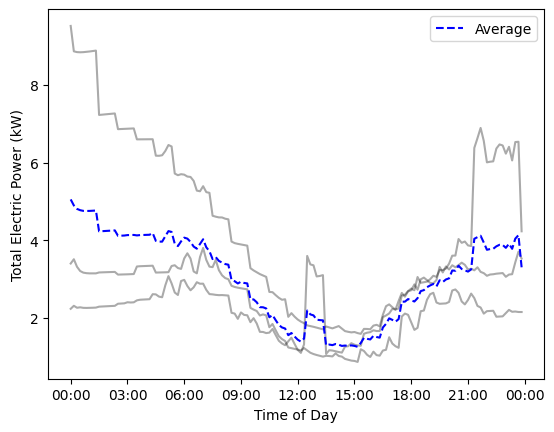

In [8]:
fig = CreateFigures.plot_daily_profile(df, 'Total Electric Power (kW)', plot_max=False, plot_min=False)

### <a name="add-equipment"></a>Adding equipment to a dwelling

Many [additional
inputs](https://ochre-nrel.readthedocs.io/en/latest/InputsAndArguments.html#dwelling-arguments)
can be specified when initializing a dwelling model. A common use case is to
add or modify equipment that are not specified in the HPXML input file. In
particular, EV, solar PV, and battery equipment are not read from the HPXML
file and must be specified during initialization.

The following code will initialize the same Dwelling and add an EV and solar
PV. For an example with more details, see
[run_dwelling.py](https://github.com/NREL/OCHRE/tree/main/bin/run_dwelling.py).


In [9]:
new_equipment = {
    "EV": {
        "vehicle_type": "BEV",
        "charging_level": "Level 1",
        "range": 200,
    },
    "PV": {
        "capacity": 5,
    },
}
new_equipment_args = {
    **dwelling_args,  # copies arguments from the above example
    "Equipment": new_equipment,
}

# Create Dwelling model
dwelling_with_new_equipment = Dwelling(**new_equipment_args)


2025-11-10 19:59:23.286886 - ochre at 2018-01-01 00:00:00: Initializing ochre (OCHRE v0.9.1)
2025-11-10 19:59:23.288010 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre.csv
2025-11-10 19:59:23.292568 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre_metrics.csv
2025-11-10 19:59:23.292568 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre_hourly.csv
2025-11-10 19:59:26.886764 - PV at 2018-01-01 00:00:00: Running SAM
2025-11-10 19:59:27.586793 - ochre at 2018-01-01 00:00:00: Dwelling Initialized


2025-11-10 19:59:27.604407 - ochre at 2018-01-01 00:00:00: Running Simulation for 3 days, 0:00:00
2025-11-10 19:59:29.305973 - ochre at 2018-01-04 00:00:00: Simulation complete, time series results saved to: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre.csv
2025-11-10 19:59:29.315013 - ochre at 2018-01-04 00:00:00: Post-processing metrics saved to: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre_metrics.csv
2025-11-10 19:59:29.333918 - ochre at 2018-01-04 00:00:00: Hourly results saved to: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre_hourly.csv


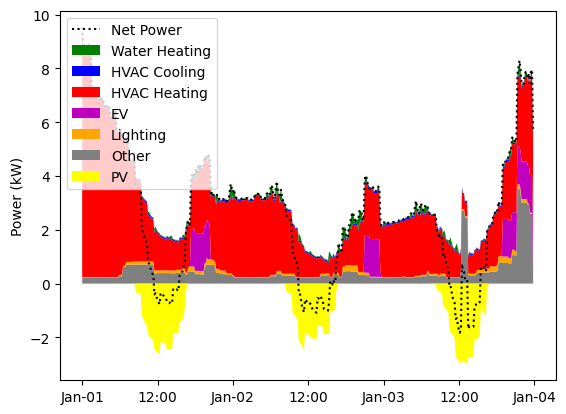

In [10]:
df, metrics, hourly = dwelling_with_new_equipment.simulate()

fig = CreateFigures.plot_power_stack(df)

### <a name="download"></a>Downloading input files

The above examples use sample files that are included in the OCHRE package. A
simple way to use other input files is to
[download](https://ochre-nrel.readthedocs.io/en/latest/InputsAndArguments.html#getting-input-files)
them from ResStock Datasets. ResStock metadata can be used to choose which
model to download.

The following code will download ResStock files (the same ones as the sample
files) to your current working directory. On Google Colab, these files can be
viewed by clicking on the folder icon on the left-hand side.


In [11]:
this_path = os.getcwd()
Analysis.download_resstock_model("bldg0112631", "up11", this_path)


bldg0112631-up11 model already downloaded, skipping


The simplest way to get weather files is through the [EnergyPlus
website](https://energyplus.net/weather). You can also upload your own files
to Colab. The following code will download an EnergyPlus weather file.

In [12]:
weather_file = "USA_CO_Denver.Intl.AP.725650_TMY3.epw"

# Note: this may not work on all systems
!wget https://energyplus-weather.s3.amazonaws.com/north_and_central_america_wmo_region_4/USA/CO/USA_CO_Denver.Intl.AP.725650_TMY3/USA_CO_Denver.Intl.AP.725650_TMY3.epw

# alternate to copy weather file from OCHRE sample files
# import shutil
# shutil.copy(os.path.join(default_input_path, "Weather", weather_file), this_path)


'wget' is not recognized as an internal or external command,
operable program or batch file.


### <a name="cli"></a>Running through the command line

OCHRE includes [command line and graphical user
interfaces](https://ochre-nrel.readthedocs.io/en/latest/Introduction.html#command-line-interface)
for simple use cases. By default, these tools will run a dwelling at hourly
resolution for one year of simulation.

After installing OCHRE, you can run ``ochre --help`` in the command line for
more information on the available options.



In [13]:
!ochre --help

Usage: ochre [OPTIONS] COMMAND [ARGS]...

  OCHRE commands

Options:
  --help  Show this message and exit.

Commands:
  hpc     Run multiple OCHRE simulations using Slurm
  local   Run multiple OCHRE simulations in parallel or in series
  single  Run single OCHRE simulation


In [14]:
!ochre single --help

Usage: ochre single [OPTIONS] INPUT_PATH

  Run single OCHRE simulation

Options:
  --name TEXT                    Simulation name (for output files)
  --hpxml_file TEXT              Name of HPXML file
  --hpxml_schedule_file TEXT     Name of HPXML schedule file
  --weather_file_or_path PATH    Path to single weather file or folder of
                                 weather files
  --output_path TEXT             Path to save output files
  --verbosity INTEGER            Verbosity of output files
  --start_year INTEGER           Simulation start year
  --start_month INTEGER          Simulation start month
  --start_day INTEGER            Simulation start day
  --time_res INTEGER             Time resolution, in minutes
  --duration INTEGER             Simulation duration, in days
  --initialization_time INTEGER  Initialization duration, in days
  --help                         Show this message and exit.


The following code will run OCHRE through the command line with the files that
you just downloaded. We reduce the duration to 3 days to reduce the
computation time.

In [15]:
!ochre single $this_path --duration=3 --weather_file_or_path=$weather_file

Usage: ochre single [OPTIONS] INPUT_PATH
Try 'ochre single --help' for help.

Error: Invalid value for '--weather_file_or_path': Path 'USA_CO_Denver.Intl.AP.725650_TMY3.epw' does not exist.


Output files can be viewed directly (in Google Colab, see the folder icon on
the left-hand side), or loaded using the following code.

In [16]:
# Load results from previous run
df, metrics, hourly = Analysis.load_ochre(this_path, "ochre")

fig = CreateFigures.plot_power_stack(df)


Missing OCHRE metrics file: C:\Users\arashjkh\OCHRE_test\bin\ochre_metrics.csv


AttributeError: 'NoneType' object has no attribute 'columns'

## <a name="equipment"></a>Simulating a single piece of equipment

OCHRE can simulate a single piece of equipment, including an electric vehicle,
water heater, solar PV system, or battery. Compared to simulating a full
dwelling, fewer input files and arguments are required. However, most
equipment require some [input
arguments](https://ochre-nrel.readthedocs.io/en/latest/InputsAndArguments.html#equipment-specific-arguments)
that often need to be specified manually.

This tutorial shows examples to simulate an EV and a water heater. For more
details and examples, see
[run_equipment.py](https://github.com/NREL/OCHRE/blob/main/bin/run_equipment.py).

### <a name="ev"></a>Simulating an electric vehicle

The following code will initialize and then simulate an [electric
vehicle](https://ochre-nrel.readthedocs.io/en/latest/ModelingApproach.html#electric-vehicles).
The vehicle type (i.e., drive train), charging level, and range must be
specified. More details on EV inputs can be found in the
[documentation](https://ochre-nrel.readthedocs.io/en/latest/InputsAndArguments.html#electric-vehicle).

In [17]:
from ochre import ElectricVehicle

equipment_args = {
    "start_time": dt.datetime(2018, 1, 1, 0, 0),  # year, month, day, hour, minute
    "time_res": dt.timedelta(minutes=15),
    "duration": dt.timedelta(days=10),
    "save_results": False,  # if True, must specify output_path
    # "output_path": os.getcwd(),
    "seed": 1,  # setting random seed to create consistent charging events

    # Equipment-specific parameters
    "vehicle_type": "BEV",
    "charging_level": "Level 1",
    "range": 200,
}

# Initialize equipment
equipment = ElectricVehicle(**equipment_args)

2025-11-10 20:00:17.311006 - EV at 2018-01-01 00:00:00: Initializing EV (OCHRE v0.9.1)


In [18]:
# Simulate equipment
df = equipment.simulate()

df.head()


2025-11-10 20:00:20.089337 - EV at 2018-01-01 00:00:00: Running Simulation for 10 days, 0:00:00
2025-11-10 20:00:20.147794 - EV at 2018-01-11 00:00:00: Simulation complete, time series results saved in memory (not to a file)


,EV Electric Power (kW),EV SOC (-),EV Unmet Load (kWh)
Time,,,
2018-01-01 00:00:00,0.0,1.0,0
2018-01-01 00:15:00,0.0,1.0,0
2018-01-01 00:30:00,0.0,1.0,0
2018-01-01 00:45:00,0.0,1.0,0
2018-01-01 01:00:00,0.0,1.0,0


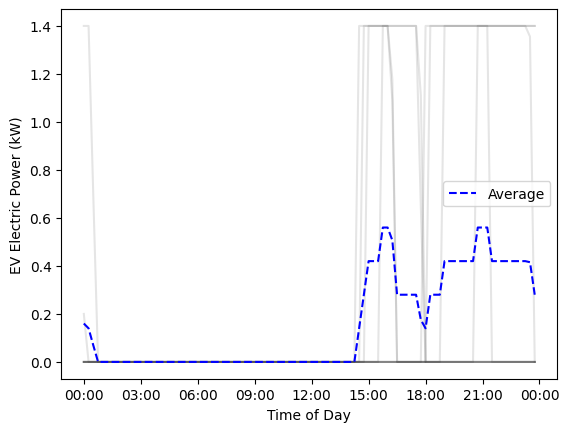

In [19]:
fig = CreateFigures.plot_daily_profile(df, "EV Electric Power (kW)", plot_max=False, plot_min=False)


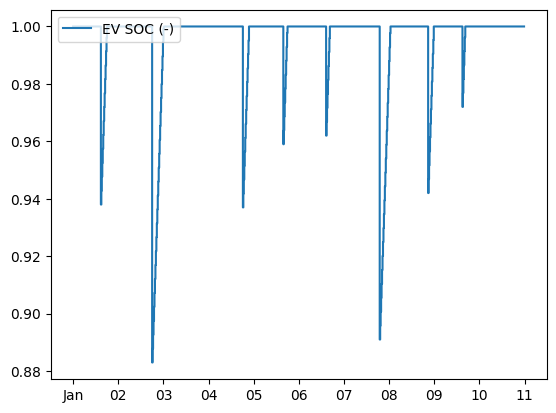

In [20]:
fig = CreateFigures.plot_time_series_detailed((df["EV SOC (-)"],))


### <a name="water_heater"></a>Simulating a water heater

The following code will initialize and then simulate a [water
heater](https://ochre-nrel.readthedocs.io/en/latest/ModelingApproach.html#water-heating).
Multiple inputs are required, including the setpoint temperature, tank size,
and heat transfer coefficient. A time series schedule is required that
includes a water draw profile, the air temperature surrounding the water
heater ("Zone Temperature"), and the water mains temperature. More details on
water heater inputs can be found in the
[documentation](https://ochre-nrel.readthedocs.io/en/latest/InputsAndArguments.html#water-heating).

In [21]:
import numpy as np
import pandas as pd
from ochre import ElectricResistanceWaterHeater

# Create water draw schedule
start_time = dt.datetime(2018, 1, 1, 0, 0)  # year, month, day, hour, minute
time_res = dt.timedelta(minutes=1)
duration = dt.timedelta(days=10)
times = pd.date_range(
    start_time,
    start_time + duration,
    freq=time_res,
    inclusive="left",
)
water_draw_magnitude = 12  # L/min
withdraw_rate = np.random.choice([0, water_draw_magnitude], p=[0.99, 0.01], size=len(times))
schedule = pd.DataFrame(
    {
        "Water Heating (L/min)": withdraw_rate,
        "Zone Temperature (C)": 20,
        "Mains Temperature (C)": 7,
    },
    index=times,
)

equipment_args = {
    "start_time": start_time,  # year, month, day, hour, minute
    "time_res": time_res,
    "duration": duration,
    "save_results": False,  # if True, must specify output_path
    # "output_path": os.getcwd(),
    # Equipment-specific parameters
    "Setpoint Temperature (C)": 51,
    "Tank Volume (L)": 250,
    "Tank Height (m)": 1.22,
    "UA (W/K)": 2.17,
    "schedule": schedule,
}

# Initialize equipment
wh = ElectricResistanceWaterHeater(**equipment_args)


2025-11-10 20:00:25.419323 - Electric Resistance Water Heater at 2018-01-01 00:00:00: Initializing Electric Resistance Water Heater (OCHRE v0.9.1)


In [22]:
# Run simulation
df = wh.simulate()

# Show results
df.head()


2025-11-10 20:00:27.142169 - Electric Resistance Water Heater at 2018-01-01 00:00:00: Running Simulation for 10 days, 0:00:00
2025-11-10 20:00:28.884803 - Electric Resistance Water Heater at 2018-01-11 00:00:00: Simulation complete, time series results saved in memory (not to a file)


,Water Heating Electric Power (kW),Hot Water Unmet Demand (kW),Hot Water Outlet Temperature (C)
Time,,,
2018-01-01 00:00:00,0.0,0.0,50.444444
2018-01-01 00:01:00,0.0,0.0,50.440326
2018-01-01 00:02:00,0.0,0.0,50.436209
2018-01-01 00:03:00,0.0,0.0,50.432091
2018-01-01 00:04:00,0.0,0.0,50.427975


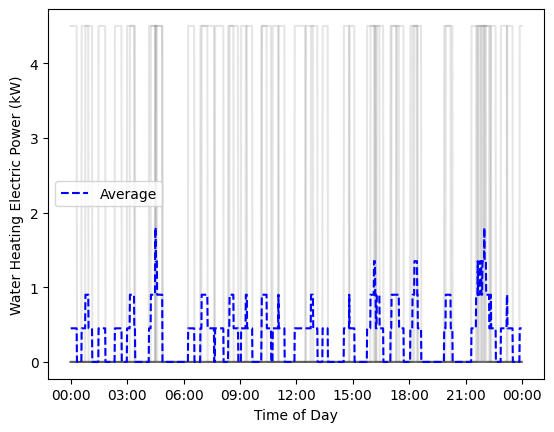

In [23]:
fig = CreateFigures.plot_daily_profile(
    df, "Water Heating Electric Power (kW)", plot_max=False, plot_min=False
)

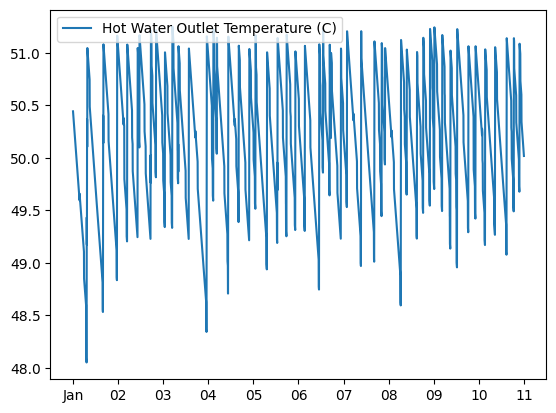

In [24]:
fig = CreateFigures.plot_time_series_detailed((df["Hot Water Outlet Temperature (C)"],))

## <a name="fleet"></a>Simulating a fleet

OCHRE can simulate multiple homes or pieces of equipment at once to model a
aggregation or a fleet of devices. The following examples show how to model a
fleet of EVs or a set of homes sequentially. Simulations can be run
sequentially or in parallel (without interactions between them) using the [command line
interface](https://ochre-nrel.readthedocs.io/en/latest/Introduction.html#command-line-interface).
See the [following section](#control) to run simulations with interactions
through external controllers.

For more details and examples, see
[run_fleet.py](https://github.com/NREL/OCHRE/blob/main/bin/run_fleet.py)
and
[run_multiple.py](https://github.com/NREL/OCHRE/blob/main/bin/run_multiple.py).

### <a name="ev-fleet"></a>Simulating an EV fleet

The following code will set up a fleet of EV models, run each one
sequentially, and then plot the power of each EV.

In [25]:
def setup_ev(i) -> ElectricVehicle:
    # randomly select vehicle type, range, and charging level
    vehicle_type = np.random.choice(["BEV", "PHEV"])
    charging_level = np.random.choice(["Level 1", "Level 2"])
    if vehicle_type == "BEV":
        range = round(np.random.uniform(100, 300))
    else:
        range = round(np.random.uniform(20, 70))

    # Option to specify a file with EV charging events
    # Defaults to older charging event data
    # equipment_event_file = None
    lvl = charging_level.lower().replace(" ", "_")
    equipment_event_file = os.path.join(default_input_path, "EV", f"{vehicle_type}_{lvl}.csv")

    # Initialize equipment
    return ElectricVehicle(
        name=f"EV_{i}",
        seed=i,  # used to randomize charging events. Not used for randomization above
        vehicle_type=vehicle_type,
        charging_level=charging_level,
        range=range,
        start_time=dt.datetime(2018, 1, 1, 0, 0),  # year, month, day, hour, minute
        time_res=dt.timedelta(minutes=15),
        duration=dt.timedelta(days=5),
        save_results=False,  # if True, must specify output_path
        # output_path=os.getcwd(),
        equipment_event_file=equipment_event_file,
    )

# Create fleet
n = 4
fleet = [setup_ev(i + 1) for i in range(n)]


2025-11-10 20:00:34.648443 - EV_1 at 2018-01-01 00:00:00: Initializing EV_1 (OCHRE v0.9.1)
2025-11-10 20:00:34.804039 - EV_2 at 2018-01-01 00:00:00: Initializing EV_2 (OCHRE v0.9.1)
2025-11-10 20:00:34.880814 - EV_2 at 2018-01-01 00:00:00: WARNING: No charging events, adding event on first day
2025-11-10 20:00:34.889294 - EV_3 at 2018-01-01 00:00:00: Initializing EV_3 (OCHRE v0.9.1)
2025-11-10 20:00:34.949078 - EV_4 at 2018-01-01 00:00:00: Initializing EV_4 (OCHRE v0.9.1)


In [26]:
def run_ev(ev: ElectricVehicle):
    df = ev.simulate()
    out = df["EV Electric Power (kW)"]
    out.name = ev.name
    return out

# Simulate fleet
results = []
for ev in fleet:
    results.append(run_ev(ev))

# combine load profiles
df = pd.concat(results, axis=1)

df.head()


2025-11-10 20:00:35.393812 - EV_1 at 2018-01-01 00:00:00: Running Simulation for 5 days, 0:00:00
2025-11-10 20:00:35.408608 - EV_1 at 2018-01-06 00:00:00: Simulation complete, time series results saved in memory (not to a file)
2025-11-10 20:00:35.408608 - EV_2 at 2018-01-01 00:00:00: Running Simulation for 5 days, 0:00:00
2025-11-10 20:00:35.446538 - EV_2 at 2018-01-06 00:00:00: Simulation complete, time series results saved in memory (not to a file)
2025-11-10 20:00:35.446538 - EV_3 at 2018-01-01 00:00:00: Running Simulation for 5 days, 0:00:00
2025-11-10 20:00:35.465823 - EV_3 at 2018-01-06 00:00:00: Simulation complete, time series results saved in memory (not to a file)
2025-11-10 20:00:35.465823 - EV_4 at 2018-01-01 00:00:00: Running Simulation for 5 days, 0:00:00
2025-11-10 20:00:35.478502 - EV_4 at 2018-01-06 00:00:00: Simulation complete, time series results saved in memory (not to a file)


,EV_1,EV_2,EV_3,EV_4
Time,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,0.0
2018-01-01 00:15:00,0.0,0.0,0.0,0.0
2018-01-01 00:30:00,0.0,0.0,0.0,0.0
2018-01-01 00:45:00,0.0,0.0,0.0,0.0
2018-01-01 01:00:00,0.0,0.0,0.0,0.0


<Axes: xlabel='Time'>

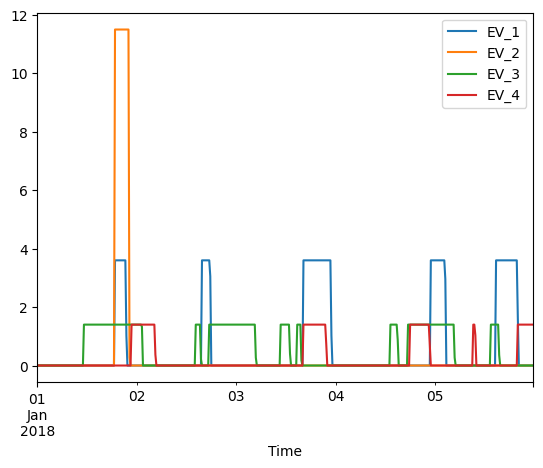

In [27]:
df.plot()


### <a name="house-fleet"></a>Simulating multiple houses

The following code will download two building models from the ResStock 2024.2
dataset and sequentially initialize and simulate them. In Google Colab, you
can view the input and output files by clicking the folder icon on the
left-hand side.

In [28]:
import shutil

from ochre import Analysis

default_weather_file_name = "USA_CO_Denver.Intl.AP.725650_TMY3.epw"
default_weather_file = os.path.join(default_input_path, "Weather", default_weather_file_name)

main_path = os.getcwd()

# Download ResStock files to current directory
buildings = ["bldg0112631"]
upgrades = ["up00", "up11"]
input_paths = []
for upgrade in upgrades:
    for building in buildings:
        input_path = os.path.join(main_path, building, upgrade)
        os.makedirs(input_path, exist_ok=True)
        Analysis.download_resstock_model(building, upgrade, input_path, overwrite=False)
        shutil.copy(default_weather_file, input_path)
        input_paths.append(input_path)

bldg0112631-up00 model already downloaded, skipping
bldg0112631-up11 model already downloaded, skipping


In [29]:
from ochre.cli import create_dwelling

# Run Dwelling models sequentially
for input_path in input_paths:
    dwelling = create_dwelling(
        input_path, duration=7, weather_file_or_path=default_weather_file_name
    )
    dwelling.simulate()

2025-11-10 20:00:38.900041 - ochre at 2018-01-01 00:00:00: Initializing ochre (OCHRE v0.9.1)
2025-11-10 20:00:38.900041 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\Users\arashjkh\OCHRE_test\bin\bldg0112631\up00\ochre.csv
2025-11-10 20:00:38.904084 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\Users\arashjkh\OCHRE_test\bin\bldg0112631\up00\ochre_metrics.csv
2025-11-10 20:00:38.904084 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\Users\arashjkh\OCHRE_test\bin\bldg0112631\up00\ochre_hourly.csv
2025-11-10 20:00:41.155427 - ochre at 2018-01-01 00:00:00: Running initialization for 1 day, 0:00:00
2025-11-10 20:00:41.212564 - ochre at 2018-01-01 00:00:00: Dwelling Initialized
2025-11-10 20:00:41.213568 - ochre at 2018-01-01 00:00:00: Running Simulation for 7 days, 0:00:00
2025-11-10 20:00:41.676453 - ochre at 2018-01-08 00:00:00: Simulation complete, time series results saved to: C:\Users\arashjkh\OCHRE_test\bin\bldg0112631\up00\

## <a name="control"></a>Simulating with external controllers

OCHRE is designed to integrate with external controllers and other modeling
tools. External controllers can adjust the power consumption of any OCHRE
equipment using multiple [control
methods](https://ochre-nrel.readthedocs.io/en/latest/ControllerIntegration.html).
The following examples show device-level control methods for HVAC systems,
EVs, and water heaters.

For more details and examples, see
[run_external_control.py](https://github.com/NREL/OCHRE/blob/main/bin/run_external_control.py).
There is also example code to run OCHRE in
[co-simulation](https://github.com/NREL/OCHRE/blob/main/bin/run_cosimulation.py)
using HELICS.

### <a name="hvac-control"></a>HVAC setpoint control

This control will reduce the heating setpoint by 1C from 5-9PM each day. It
adjusts the setpoint schedule before beginning the simulation; however, this
control can be achieved by [setting the
setpoint](https://ochre-nrel.readthedocs.io/en/latest/ControllerIntegration.html#hvac-heating-or-hvac-cooling)
at every time step as well. We use the same house model as the first example.

In [30]:
# Update the simulation args to run at a finer time resolution
dwelling_args.update(
    {
        "time_res": dt.timedelta(minutes=1),  # time resolution of the simulation
        "duration": dt.timedelta(days=1),  # duration of the simulation
        "verbosity": 6,  # increases the number of results for plotting (default=3)
    }
)

# Initialize the Dwelling
dwelling = Dwelling(**dwelling_args)

# Get HVAC heater schedule
heater = dwelling.get_equipment_by_end_use("HVAC Heating")
schedule = heater.schedule

# Reduce heating setpoint by 1C from 5-9PM (setpoint is already in the schedule)
peak_times = (schedule.index.hour >= 17) & (schedule.index.hour < 21)
schedule.loc[peak_times, "HVAC Heating Setpoint (C)"] -= 1

# Adjust the HVAC deadband temperature (not in the schedule yet)
schedule["HVAC Heating Deadband (C)"] = 1
schedule.loc[peak_times, "HVAC Heating Deadband (C)"] = 2

# Reset the schedule to implement the changes
heater.reset_time()

# Simulate
df, _, _ = dwelling.simulate()


2025-11-10 20:00:45.107518 - ochre at 2018-01-01 00:00:00: Initializing ochre (OCHRE v0.9.1)
2025-11-10 20:00:45.108517 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre.csv
2025-11-10 20:00:45.112534 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre_metrics.csv
2025-11-10 20:00:45.112534 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre_hourly.csv
2025-11-10 20:00:46.452514 - ochre at 2018-01-01 00:00:00: Dwelling Initialized
2025-11-10 20:00:46.461876 - ochre at 2018-01-01 00:00:00: Running Simulation for 1 day, 0:00:00
2025-11-10 20:00:50.377114 - ochre at 2018-01-02 00:00:00: Simulation complete, time series results saved to: C:\Users\arashjkh\OCHRE_test\ochre\defaults\Input Files\ochre.csv
2025-11-10 20:00:50.386539 - ochre at 2018-01-02 00:00:00: Post-proc

<Axes: xlabel='Time'>

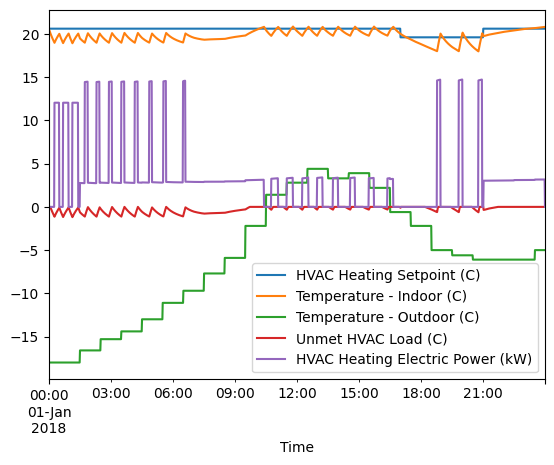

In [31]:
cols_to_plot = [
    "HVAC Heating Setpoint (C)",
    "Temperature - Indoor (C)",
    "Temperature - Outdoor (C)",
    "Unmet HVAC Load (C)",
    "HVAC Heating Electric Power (kW)",
]
df.loc[:, cols_to_plot].plot()


### <a name="ev-control"></a>EV managed charging

This control implements "perfect" managed charging for an EV. At each time
step, it calculates the average power required to achieve 100% SOC by the end
of the parking session, and sets the charging power to that value. Other [EV
control
options](https://ochre-nrel.readthedocs.io/en/latest/ControllerIntegration.html#electric-vehicle-ev)
are described in the documentation.

In [32]:
from ochre.Equipment.EV import EV_EFFICIENCY

equipment_args = {
    "start_time": dt.datetime(2018, 1, 1, 0, 0),  # year, month, day, hour, minute
    "time_res": dt.timedelta(minutes=60),
    "duration": dt.timedelta(days=20),
    "verbosity": 3,
    "save_results": False,  # if True, must specify output_path
    # "output_path": os.getcwd(),
    # Equipment parameters
    "vehicle_type": "BEV",
    "charging_level": "Level 1",
    "range": 150,
}

# Initialize
ev = ElectricVehicle(**equipment_args)

# slow charge from start to end of parking
for t in ev.sim_times:
    remaining_hours = (ev.event_end - t).total_seconds() / 3600
    remaining_kwh = (1 - ev.soc) * ev.capacity
    if t >= ev.event_start and remaining_hours:
        power = remaining_kwh / remaining_hours / EV_EFFICIENCY
        ev.update({"Max Power": power})
    else:
        ev.update()

df = ev.finalize()


2025-11-10 20:00:50.815250 - EV at 2018-01-01 00:00:00: Initializing EV (OCHRE v0.9.1)
2025-11-10 20:00:52.874087 - EV at 2018-01-21 00:00:00: Simulation complete, time series results saved in memory (not to a file)


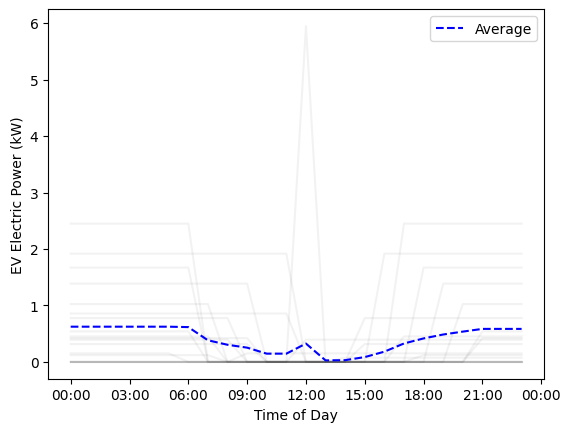

In [33]:
fig = CreateFigures.plot_daily_profile(df, "EV Electric Power (kW)", plot_max=False, plot_min=False)


<Axes: xlabel='Time'>

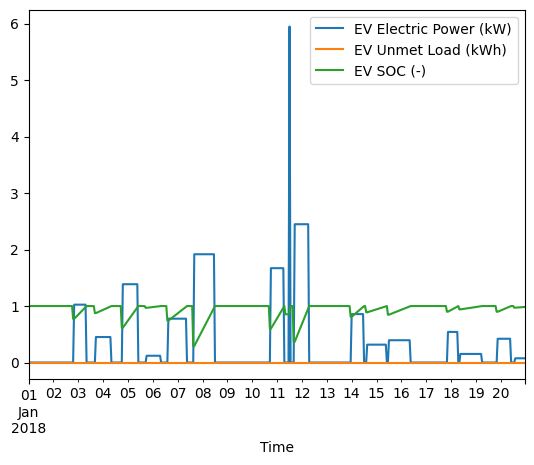

In [34]:
df.loc[:, ["EV Electric Power (kW)", "EV Unmet Load (kWh)", "EV SOC (-)"]].plot()


### <a name="wh-control"></a>HPWH CTA-2045 control

This control implements the CTA-2045 Load Add and Load Shed control for a heat
pump water heater. The control will adjust the setpoint and deadband of the
water heater thermostat to increase load for 1 hour (at 7AM and 4PM) and then
reduce load for 1 hour (at 8AM and 5PM). Other [water heater control
options](https://ochre-nrel.readthedocs.io/en/latest/ControllerIntegration.html#water-heating)
are described in the documentation.

In [35]:
from ochre import HeatPumpWaterHeater

# Define equipment and simulation parameters
setpoint_default = 51  # in C
deadband_default = 5.56  # in C
equipment_args = {
    "start_time": dt.datetime(2018, 1, 1, 0, 0),  # year, month, day, hour, minute
    "time_res": dt.timedelta(minutes=1),
    "duration": dt.timedelta(days=1),
    "verbosity": 7,  # required to get setpoint and deadband in results
    "save_results": False,  # if True, must specify output_path
    # "output_path": os.getcwd(),        # Equipment parameters
    "Setpoint Temperature (C)": setpoint_default,
    "Tank Volume (L)": 250,
    "Tank Height (m)": 1.22,
    "UA (W/K)": 2.17,
    "HPWH COP (-)": 4.5,
}

# Create water draw schedule
times = pd.date_range(
    equipment_args["start_time"],
    equipment_args["start_time"] + equipment_args["duration"],
    freq=equipment_args["time_res"],
    inclusive="left",
)
water_draw_magnitude = 12  # L/min
withdraw_rate = np.random.choice([0, water_draw_magnitude], p=[0.99, 0.01], size=len(times))
schedule = pd.DataFrame(
    {
        "Water Heating (L/min)": withdraw_rate,
        "Water Heating Setpoint (C)": setpoint_default,  # Setting so that it can reset
        "Water Heating Deadband (C)": deadband_default,  # Setting so that it can reset
        "Zone Temperature (C)": 20,
        "Zone Wet Bulb Temperature (C)": 15,  # Required for HPWH
        "Mains Temperature (C)": 7,
    },
    index=times,
)

# Initialize equipment
hpwh = HeatPumpWaterHeater(schedule=schedule, **equipment_args)

# Simulate
control_signal = {}
for t in hpwh.sim_times:
    # Change setpoint based on hour of day
    if t.hour in [7, 16]:
        # CTA-2045 Basic Load Add command
        control_signal = {"Deadband": deadband_default - 2.78}
    elif t.hour in [8, 17]:
        # CTA-2045 Load Shed command
        control_signal = {
            "Setpoint": setpoint_default - 5.56,
            "Deadband": deadband_default - 2.78,
        }
    else:
        control_signal = {}

    # Run with controls
    _ = hpwh.update(control_signal=control_signal)

df = hpwh.finalize()

df.head()


2025-11-10 20:00:53.415845 - Heat Pump Water Heater at 2018-01-01 00:00:00: Initializing Heat Pump Water Heater (OCHRE v0.9.1)
2025-11-10 20:00:53.684679 - Heat Pump Water Heater at 2018-01-02 00:00:00: Simulation complete, time series results saved in memory (not to a file)


,Water Heating Electric Power (kW),Water Heating Mode,Water Heating Delivered (W),Water Heating COP (-),Water Heating Total Sensible Heat Gain (W),Water Heating Deadband Upper Limit (C),Water Heating Deadband Lower Limit (C),Water Heating Heat Pump Max Capacity (W),Water Heating Heat Pump On Fraction (-),Water Heating Heat Pump COP (-),Hot Water Unmet Demand (kW),Hot Water Outlet Temperature (C),Hot Water Delivered (L/min),Hot Water Delivered (W),Hot Water Heat Injected (W),Hot Water Heat Loss (W),Hot Water Average Temperature (C),Hot Water Maximum Temperature (C),Hot Water Minimum Temperature (C),Hot Water Mains Temperature (C)
Time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.001,Off,0.0,0.0,50.294787,51.0,45.44,2291.390472,0,4.465457,0.0,50.444444,0.0,0.0,0.0,66.059716,50.444444,50.444444,50.444444,7.0
2018-01-01 00:01:00,0.001,Off,0.0,0.0,50.287696,51.0,45.44,2291.476999,0,4.465788,0.0,50.437376,0.0,0.0,0.0,66.050261,50.440654,50.441310,50.437376,7.0
2018-01-01 00:02:00,0.001,Off,0.0,0.0,50.280607,51.0,45.44,2291.563529,0,4.466118,0.0,50.430312,0.0,0.0,0.0,66.040810,50.436865,50.438176,50.430312,7.0
2018-01-01 00:03:00,0.001,Off,0.0,0.0,50.273520,51.0,45.44,2291.650062,0,4.466449,0.0,50.423254,0.0,0.0,0.0,66.031361,50.433076,50.435043,50.423254,7.0
2018-01-01 00:04:00,0.001,Off,0.0,0.0,50.266436,51.0,45.44,2291.736599,0,4.466780,0.0,50.416201,0.0,0.0,0.0,66.021915,50.429287,50.431910,50.416201,7.0


<Axes: xlabel='Time'>

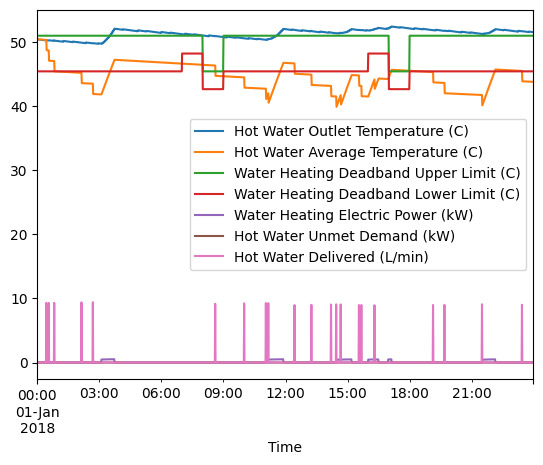

In [36]:
cols_to_plot = [
    "Hot Water Outlet Temperature (C)",
    "Hot Water Average Temperature (C)",
    "Water Heating Deadband Upper Limit (C)",
    "Water Heating Deadband Lower Limit (C)",
    "Water Heating Electric Power (kW)",
    "Hot Water Unmet Demand (kW)",
    "Hot Water Delivered (L/min)",
]
df.loc[:, cols_to_plot].plot()
